In [1]:
# import lib
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv('D:/project_data_mining/src/dataset.csv')

In [3]:
# encode category 
df["cat_id"] = df["Expenditure_category"].astype("category").cat.codes

In [4]:
# create lag features
def create_lag_features(df):

    # CPI lags
    for lag in [1, 3, 6, 12]:
        df[f"CPI_lag_{lag}"] = (
            df.groupby("Expenditure_category")["CPI"].shift(lag)
        )

    # Energy lags
    for lag in [1, 3]:
        df[f"Energy_lag_{lag}"] = (
            df.groupby("Expenditure_category")["Energy"].shift(lag)
        )

    # GDP lag
    df["GDP_lag_1"] = (
        df.groupby("Expenditure_category")["GDP"].shift(1)
    )

    return df



In [5]:
# rolling statistics
def create_rolling_features(df):

    df["CPI_roll_mean_3"] = (
        df.groupby("Expenditure_category")["CPI"]
          .shift(1)
          .rolling(3)
          .mean()
    )

    df["CPI_roll_std_6"] = (
        df.groupby("Expenditure_category")["CPI"]
          .shift(1)
          .rolling(6)
          .std()
    )

    return df



In [6]:
df = create_lag_features(df)
df = create_rolling_features(df)

# Drop NaN sinh ra do lag/rolling
df_ml = df.dropna().reset_index(drop=True)


In [ ]:
# # split train/val/test 
train_df = df[(df["TIME_PERIOD"] >= "2011-01-01") & (df["TIME_PERIOD"] <= "2020-12-31")]
val_df   = df[(df["TIME_PERIOD"] >= "2021-01-01") & (df["TIME_PERIOD"] <= "2022-12-31")]
test_df  = df[(df["TIME_PERIOD"] >= "2023-01-01") & (df["TIME_PERIOD"] <= "2025-12-31")]


In [8]:
print(train_df.columns.tolist())


['Expenditure_category', 'TIME_PERIOD', 'CPI', 'Energy', 'YEAR', 'GDP', 'cat_id', 'CPI_lag_1', 'CPI_lag_3', 'CPI_lag_6', 'CPI_lag_12', 'Energy_lag_1', 'Energy_lag_3', 'GDP_lag_1', 'CPI_roll_mean_3', 'CPI_roll_std_6']


In [ ]:
# feature set 
features = [
    "cat_id",
    "CPI_lag_1", "CPI_lag_3", "CPI_lag_6", "CPI_lag_12",
    "Energy_lag_1", "Energy_lag_3",
    "GDP_lag_1",
    "CPI_roll_mean_3", "CPI_roll_std_6"
]

X_train = train_df[features]
y_train = train_df["CPI"]

X_val = val_df[features]
y_val = val_df["CPI"]

X_test = test_df[features]
y_test = test_df["CPI"]


In [10]:
rf = RandomForestRegressor(
    n_estimators=500,
    max_depth=15,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)



,n_estimators,500
,criterion,'squared_error'
,max_depth,15
,min_samples_split,2
,min_samples_leaf,5
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [ ]:
# eval
def smape(y_true, y_pred):
    return np.mean(
        2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred))
    ) * 100

def pred_within_10pct(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true) / y_true <= 0.10) * 100

def evaluate_global(y_true, y_pred, name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    smp  = smape(y_true, y_pred)
    p10  = pred_within_10pct(y_true, y_pred)

    print(f"\n{name}(GLOBAL MODEL)")
    print(f"RMSE  : {rmse:.3f}")
    print(f"MAE   : {mae:.3f}")
    print(f"sMAPE : {smp:.2f}%")
    print(f"Pred<10% : {p10:.2f}%")


In [ ]:
# results
val_pred  = rf.predict(X_val)
test_pred = rf.predict(X_test)

evaluate_global(y_val, val_pred,  "Validation")
evaluate_global(y_test, test_pred, "Test")



Validation
RMSE  : 0.917
MAE   : 0.590
sMAPE : 0.65%
Pred<10% : 100.00%

Test
RMSE  : 0.886
MAE   : 0.661
sMAPE : 0.66%
Pred<10% : 100.00%


In [16]:
# CPI actual vs CPI predict
test_results = test_df[["TIME_PERIOD","Expenditure_category","CPI"]].copy()

test_results["CPI_pred_RF"] = test_pred

test_results.head()

,TIME_PERIOD,Expenditure_category,CPI,CPI_pred_RF
156,2025-01-01,All Items,99.908,100.340944
157,2025-02-01,All Items,100.677,99.712772
158,2025-03-01,All Items,100.599,100.425482
159,2025-04-01,All Items,100.283,100.251727
160,2025-05-01,All Items,100.978,99.995188


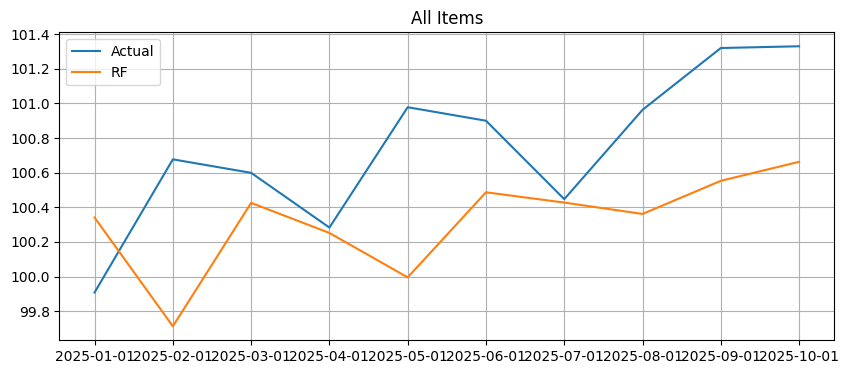

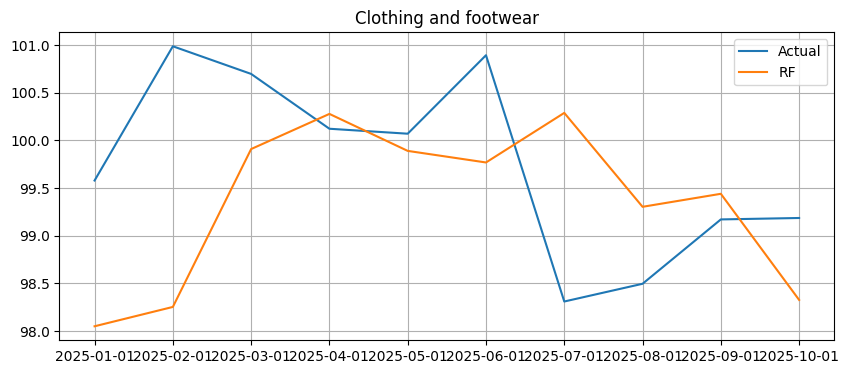

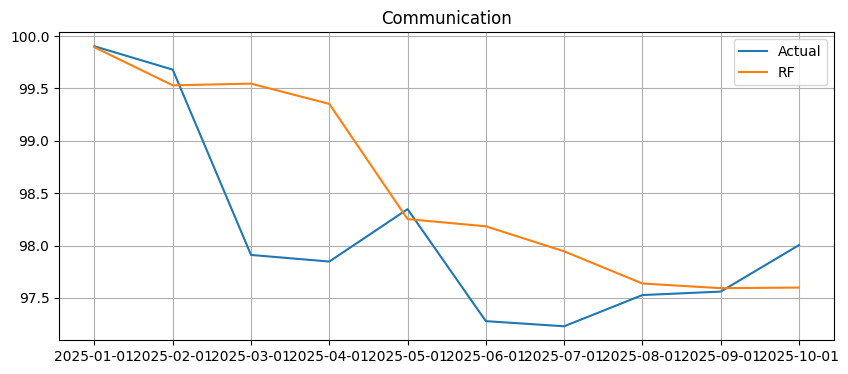

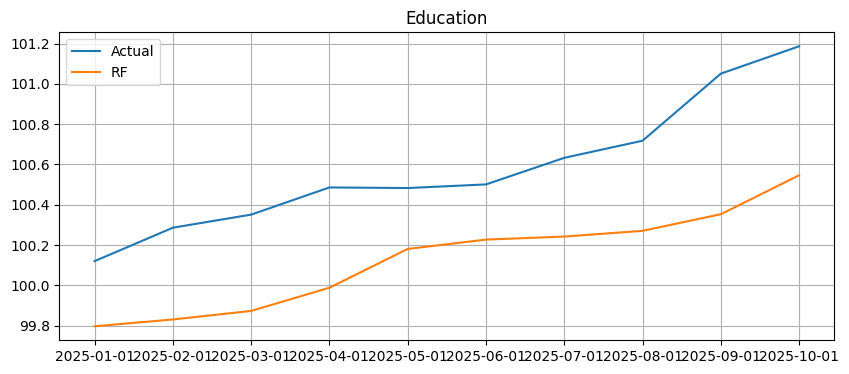

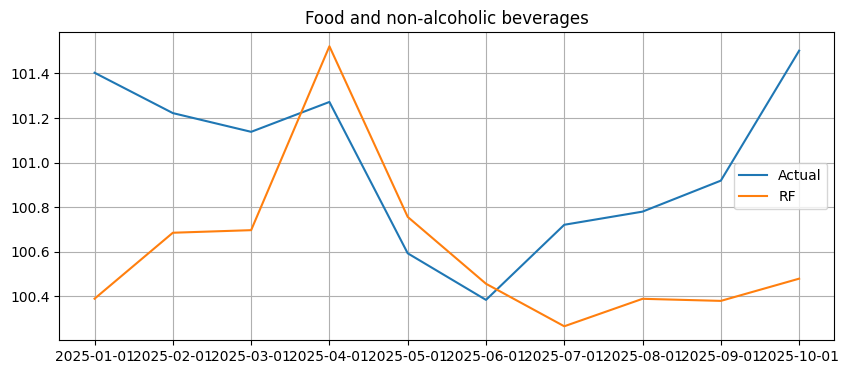

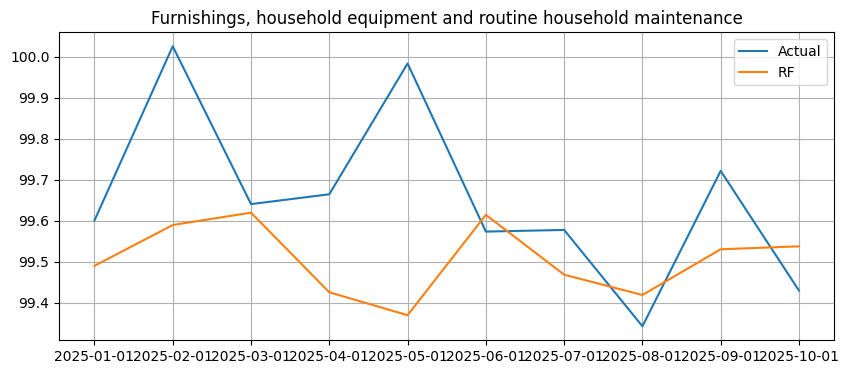

In [14]:
# visualize 
def plot_rf_results(df, n_cat=6):
    cats = df["Expenditure_category"].unique()[:n_cat]

    for cat in cats:
        d = df[df["Expenditure_category"] == cat]

        plt.figure(figsize=(10,4))
        plt.plot(d["TIME_PERIOD"], d["CPI"], label="Actual")
        plt.plot(d["TIME_PERIOD"], d["CPI_pred_RF"], label="RF")
        plt.title(cat)
        plt.legend()
        plt.grid(True)
        plt.show()

plot_rf_results(test_results)

